In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import math
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import Preprocessor
import cv2
import LayersConstructor
from sklearn.metrics import confusion_matrix
from datetime import timedelta
from tensorflow.python.framework import ops
from sklearn.metrics.classification import accuracy_score 
from sklearn.metrics import precision_recall_fscore_support

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
ops.reset_default_graph()

In [4]:
filter_size1 = 3 
num_filters1 = 32

In [5]:
filter_size2 = 3
num_filters2 = 32

In [6]:
filter_size3 = 3
num_filters3 = 64

In [7]:
fc_size = 128

In [8]:
learning_rate=1e-4 

In [9]:
num_channels = 3

In [10]:
img_size = 128

In [11]:
img_size_flat = img_size * img_size * num_channels

In [12]:
img_shape = (img_size, img_size)

In [13]:
classes = ['dogs', 'cats']
num_classes = len(classes)

In [14]:
batch_size = 32

In [15]:
validation_size = 0.16

In [16]:
early_stopping = None

In [17]:
train_path = 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/train/'
test_path = 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/test/'
checkpoint_dir = "C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/models/"

In [18]:
data = Preprocessor.read_train_sets(train_path, img_size, classes, validation_size=validation_size)
test_images, test_ids = Preprocessor.read_test_set(test_path, img_size)

Reading training images
Loading dogs files (Index: 0)
Loading cats files (Index: 1)
Reading test images


In [19]:
def plot_images(images, cls_true, cls_pred=None):    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


In [20]:
images, cls_true  = data.train.images, data.train.cls

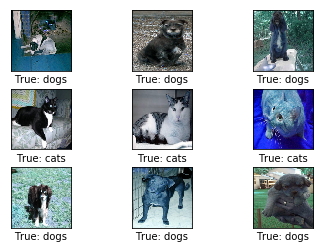

In [21]:
plot_images(images=images, cls_true=cls_true)

In [22]:
print("Size of:")
print("  - Training-set:\t\t{}".format(len(data.train.labels)))
print("  - Test-set:\t\t{}".format(len(test_images)))
print("  - Validation-set:\t{}".format(len(data.valid.labels)))

Size of:
  - Training-set:		168
  - Test-set:		100
  - Validation-set:	32


In [23]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


In [24]:
layer_conv1, weights_conv1 = \
    LayersConstructor.new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

layer_conv2, weights_conv2 = \
    LayersConstructor.new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

layer_conv3, weights_conv3 = \
    LayersConstructor.new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)

layer_flat, num_features = LayersConstructor.flatten_layer(layer_conv3)
layer_fc1 = LayersConstructor.new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc2 = LayersConstructor.new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [25]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                        labels=y_true)

In [26]:
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [27]:
init_op = tf.global_variables_initializer()
session = tf.Session()
session.run(init_op)

In [28]:
train_batch_size = batch_size
acc_list = []
val_acc_list = []

In [29]:
total_iterations = 0
iter_list = []

In [30]:
def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    # Calculate the accuracy on the training-set.
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    return acc, val_acc

In [31]:
def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations, total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(train_batch_size)

        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, flattened image shape]

        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch, y_true: y_true_batch}        
        feed_dict_validate = {x: x_valid_batch, y_true: y_valid_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)        

        # Print status at end of each epoch (defined as full pass through training Preprocessor).
        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            epoch = int(i / int(data.train.num_examples/batch_size))
            
            acc, val_acc = print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss)
            msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
            print(msg.format(epoch + 1, acc, val_acc, val_loss))
            print(acc)
            acc_list.append(acc)
            val_acc_list.append(val_acc)
            iter_list.append(epoch+1)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1
                if patience == early_stopping:
                    break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

In [32]:
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.valid.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.valid.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])

In [33]:
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.valid.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    
    # Compute the precision, recall and f1 score of the classification
    p, r, f, s = precision_recall_fscore_support(cls_true, cls_pred, average='weighted')
    print('Precision:', p)
    print('Recall:', r)
    print('F1-score:', f)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [34]:
def print_validation_accuracy(show_example_errors=False, show_confusion_matrix=False):
    # Number of images in the test-set.
    num_test = len(data.valid.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.valid.images[i:j, :].reshape(batch_size, img_size_flat)
        

        # Get the associated labels.
        labels = data.valid.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images, y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [35]:
optimize(num_iterations = 100)

Epoch 1 --- Training Accuracy:  53.1%, Validation Accuracy:  53.1%, Validation Loss: 0.690
0.53125
Epoch 2 --- Training Accuracy:  46.9%, Validation Accuracy:  46.9%, Validation Loss: 0.703
0.46875
Epoch 3 --- Training Accuracy:  84.4%, Validation Accuracy:  65.6%, Validation Loss: 0.688
0.84375
Epoch 4 --- Training Accuracy:  78.1%, Validation Accuracy:  56.2%, Validation Loss: 0.688
0.78125
Epoch 5 --- Training Accuracy:  46.9%, Validation Accuracy:  50.0%, Validation Loss: 0.692
0.46875
Epoch 6 --- Training Accuracy:  71.9%, Validation Accuracy:  56.2%, Validation Loss: 0.688
0.71875
Epoch 7 --- Training Accuracy:  75.0%, Validation Accuracy:  56.2%, Validation Loss: 0.686
0.75
Epoch 8 --- Training Accuracy:  71.9%, Validation Accuracy:  56.2%, Validation Loss: 0.687
0.71875
Epoch 9 --- Training Accuracy:  75.0%, Validation Accuracy:  56.2%, Validation Loss: 0.685
0.75
Epoch 10 --- Training Accuracy:  81.2%, Validation Accuracy:  53.1%, Validation Loss: 0.684
0.8125
Epoch 11 --- Tra

[0.53125, 0.46875, 0.84375, 0.78125, 0.46875, 0.71875, 0.75, 0.71875, 0.75, 0.8125, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.90625, 0.90625, 0.90625]


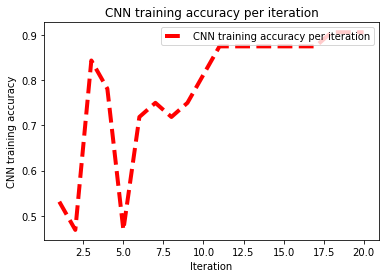

In [36]:
print(acc_list)
plt.plot(iter_list, acc_list, 'r--', label='CNN training accuracy per iteration', linewidth=4)
plt.title('CNN training accuracy per iteration')
plt.xlabel('Iteration')
plt.ylabel('CNN training accuracy')
plt.legend(loc='upper right')
plt.show()

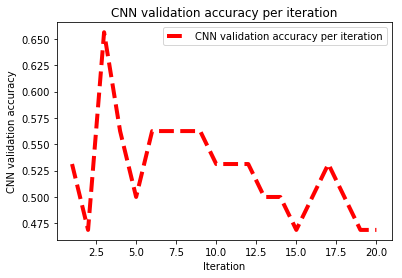

In [37]:
plt.plot(iter_list, val_acc_list, 'r--', label='CNN validation accuracy per iteration', linewidth=4)
plt.title('CNN validation accuracy per iteration')
plt.xlabel('Iteration')
plt.ylabel('CNN validation accuracy')
plt.legend(loc='upper right')
plt.show() 

Accuracy on Test-Set: 50.0% (16 / 32)
Example errors:


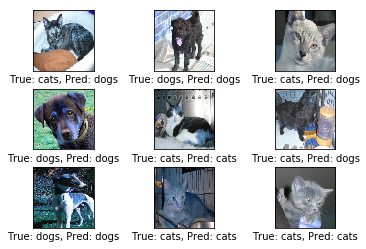

Confusion Matrix:
Precision: 0.5129870129870129
Recall: 0.5
F1-score: 0.48809523809523814
[[ 6 11]
 [ 5 10]]


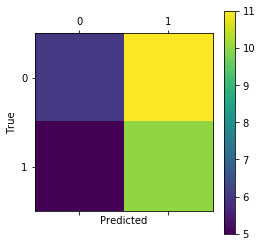

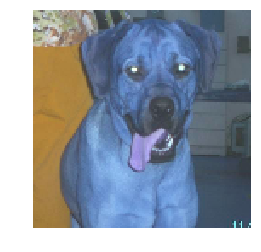

In [38]:
testPathCat = 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/Test_image/cat.jpg'
testPathDog = 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/Test_image/dog.jpg'

print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)
plt.axis('off')
test_cat = cv2.imread(testPathCat)
test_cat = cv2.resize(test_cat, (img_size, img_size), cv2.INTER_LINEAR) / 255
preview_cat = plt.imshow(test_cat.reshape(img_size, img_size, num_channels))

test_dog = cv2.imread(testPathDog)
test_dog = cv2.resize(test_dog, (img_size, img_size), cv2.INTER_LINEAR) / 255
preview_dog = plt.imshow(test_dog.reshape(img_size, img_size, num_channels))

In [39]:
def sample_prediction(test_im):    
    feed_dict_test = {
        x: test_im.reshape(1, img_size_flat),
        y_true: np.array([[1, 0]])
    }
    test_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    return classes[test_pred[0]]

print("Predicted class for test_cat: {}".format(sample_prediction(test_cat)))
print("Predicted class for test_dog: {}".format(sample_prediction(test_dog)))

Predicted class for test_cat: dogs
Predicted class for test_dog: dogs


In [40]:
session.close()